# Compare Facebook with survey data

In [17]:
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import json

## Load data

In [80]:
ad_estimates = pd.read_csv('../../data/query_results/hispanic_expats.tsv', sep='\t', index_col=False)
survey_data = pd.read_csv('../../data/pop_stats/CURRENT_Statistical-Portrait-of-the-Foreign-Born-2015_FINAL.txt', sep='\t', index_col=0)
state_data = pd.read_csv('../../data/pop_stats/state_pop_stats.tsv', sep='\t', index_col=0)
# join
idx_overlap = list(set(survey_data.index) & set(state_data.index))
survey_data = survey_data.loc[idx_overlap, :]
state_data = state_data.loc[idx_overlap, :]
survey_data.loc[:, 'total_pop'] = state_data.loc[:, 'July 2015']
# clean up numbers
survey_data = survey_data.applymap(lambda x: int(str(x).replace(',', '')))
# clean up JSON
json_cols = ['geo_locations', 'behavior', 'response', 'ages_ranges']
for c in json_cols:
    ad_estimates.loc[:, c] = ad_estimates.loc[:, c].apply(lambda x: json.loads(x.replace("u'", "'").replace("'", '"')))

In [81]:
ad_estimates.head(2)

,name,interests,ages_ranges,genders,behavior,scholarities,languages,family_statuses,relationship_statuses,geo_locations,household_composition,all_fields,targeting,response,dau_audience,mau_audience,timestamp,publisher_platforms
0,Hispanic Expats,NaN,{u'min': 18},0.0,"{u'or': [6003133212372], u'name': u'Hispanic (...",NaN,NaN,NaN,NaN,"{u'country': u'US', u'values': [{u'key': u'384...",NaN,"(('genders', 0), ('ages_ranges', {u'min': 18})...","{""flexible_spec"": [{""behaviors"": [{""id"": 60031...","{u'data': [{u'estimate_mau': 180000, u'estimat...",131267,180000,1526987902,"[""facebook""]"
1,Hispanic Expats,NaN,{u'min': 18},0.0,"{u'not': [6003133212372], u'name': u'Non-Hispa...",NaN,NaN,NaN,NaN,"{u'country': u'US', u'values': [{u'key': u'384...",NaN,"(('genders', 0), ('ages_ranges', {u'min': 18})...","{""flexible_spec"": [], ""publisher_platforms"": [...","{u'data': [{u'estimate_mau': 3000000, u'estima...",1989473,3000000,1526987902,"[""facebook""]"


In [82]:
survey_data.head(3)

,Foreign born,Mexico,South and East Asia,Europe/ Canada,Caribbean,Central America,South America,Middle East,Sub-Saharan Africa,All other,Hispanic,total_pop
Mississippi,68413,24604,19246,9951,2558,5761,1912,1106,3055,0,32923,2992333
Oklahoma,232813,112976,58422,18011,1971,20075,7609,6411,6327,1011,135022,3911338
Wyoming,18758,8805,3766,3188,0,0,0,0,1246,0,8805,586107


## Clean data
Let's clean up the data to include state and percent population foreign-born Hispanic (`hispanic_pct`).

In [83]:
survey_data.loc[:, 'hispanic_pct'] = survey_data.loc[:, 'Hispanic'] / survey_data.loc[:, 'total_pop']
survey_data.loc[:, 'hispanic_pct'].sort_values(inplace=False, ascending=False).head(10)

California    0.133146
Florida       0.115678
Texas         0.110499
Nevada        0.102722
New York      0.081519
Arizona       0.080987
New Mexico    0.069278
New Jersey    0.065702
Illinois      0.061013
Colorado      0.049364
Name: hispanic_pct, dtype: float64

To reassign the states we need to reload the ID-state pairs.

In [95]:
id_state_data = pd.read_csv('../../data/query_results/state_locs.tsv', sep='\t', index_col=False)
id_state_lookup = dict(zip(id_state_data.loc[:, 'key'].values, id_state_data.loc[:, 'name'].values))
ad_estimates.loc[:, 'state'] = ad_estimates.loc[:, 'geo_locations'].apply(lambda x: id_state_lookup.get(int(x['values'][0]['key'])))

We also need to specify Hispanic Ex-pat versus non-Hispanic Ex-pat.

In [101]:
ad_estimates.loc[:, 'demo_group'] = ad_estimates.loc[:, 'behavior'].apply(lambda x: x['name'])

In [109]:
# compute Hispanic percent for MAU and DAU
hisp_name = 'Hispanic (US - All)'
non_hisp_name = 'Non-Hispanic'
dau_hispanic_pct = ad_estimates.groupby('state').apply(lambda x: (x[x.loc[:, 'demo_group'] == hisp_name].loc[:, 'dau_audience'].iloc[0].astype(float) / 
                                                                  x.loc[:, 'dau_audience'].sum()))
mau_hispanic_pct = ad_estimates.groupby('state').apply(lambda x: (x[x.loc[:, 'demo_group'] == hisp_name].loc[:, 'mau_audience'].iloc[0].astype(float) / 
                                                                  x.loc[:, 'mau_audience'].sum()))

Combine everything into one frame!

In [126]:
hispanic_data = pd.concat([survey_data.loc[:, 'hispanic_pct'], 
                           dau_hispanic_pct,
                           mau_hispanic_pct], axis=1)
hispanic_data.columns = ['Hispanic_pct_survey', 'Hispanic_pct_FB_DAU', 'Hispanic_pct_FB_MAU']
# remove nan rows
hispanic_data = hispanic_data[~ hispanic_data.apply(lambda x: pd.np.any(pd.np.isnan(x)), axis=1)]
hispanic_data.head()

,Hispanic_pct_survey,Hispanic_pct_FB_DAU,Hispanic_pct_FB_MAU
Alabama,0.016587,0.061897,0.056604
Alaska,0.005945,0.053194,0.044715
Arizona,0.080987,0.350390,0.295455
Arkansas,0.028798,0.087582,0.081633
California,0.133146,0.371369,0.317269


These counts look reasonable, although sometimes the Facebook estimates are all overestimates (sometimes by factor of 10, e.g. Alaska??). 

Let's look at the bivariate distributions to see if the counts roughly line up.

## Plot Facebook and survey estimates

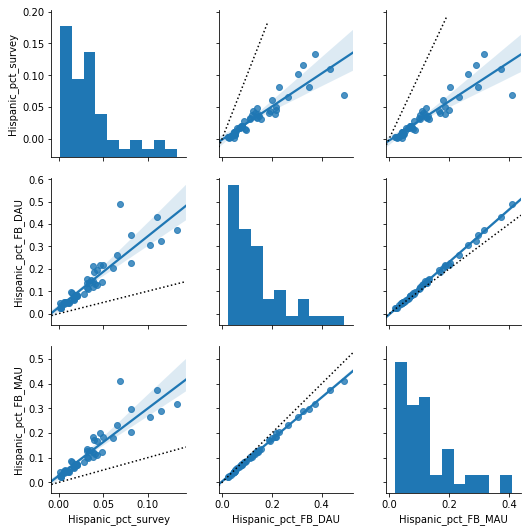

In [134]:
import seaborn as sns
pair_grid = sns.pairplot(hispanic_data, kind='reg')
M = hispanic_data.shape[1]
for i in range(M):
    for j in range(M):
        if(i != j):
            ax = pair_grid.axes[i][j]
            x0, x1 = ax.get_xlim()
            y0, y1 = ax.get_ylim()
            lims = [max(x0, y0), min(x1, y1)]
            ax.plot(lims, lims, ':k')
plt.show()

OK! We see that the Facebook estimates overestimate the survey response, and this seems to get worse with higher survey responses.

What do the raw population counts look like?

In [146]:
survey_data.loc[:, 'Hispanic']
ad_estimate_hispanic = ad_estimates[ad_estimates.loc[:, 'demo_group'] == hisp_name]
ad_estimate_hispanic.index = ad_estimate_hispanic.loc[:, 'state']
dau_hispanic_count = ad_estimate_hispanic.loc[:, 'dau_audience']
mau_hispanic_count = ad_estimate_hispanic.loc[:, 'mau_audience']
hispanic_count_data = pd.concat([survey_data.loc[:, 'Hispanic'], 
                                 dau_hispanic_count, 
                                 mau_hispanic_count], axis=1)
hispanic_count_data = hispanic_count_data[~ hispanic_count_data.apply(lambda x: pd.np.any(pd.np.isnan(x)), axis=1)]

In [147]:
hispanic_count_data.head()

,Hispanic,dau_audience,mau_audience
Alabama,80598.0,131267.0,180000.0
Alaska,4390.0,17013.0,22000.0
Arizona,552982.0,957492.0,1300000.0
Arkansas,85767.0,117054.0,160000.0
California,5211963.0,5376962.0,7900000.0


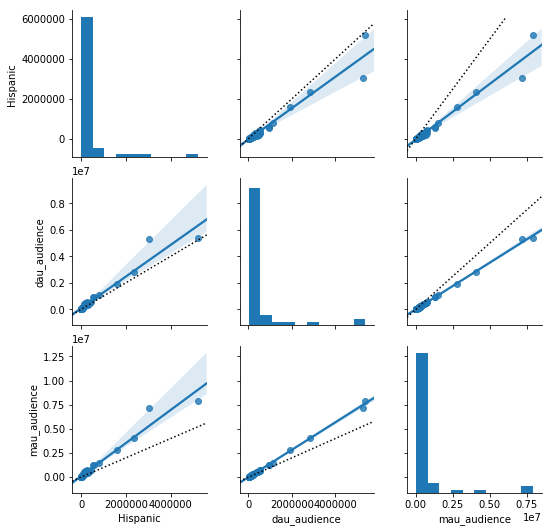

In [148]:
pair_grid = sns.pairplot(hispanic_count_data, kind='reg')
M = hispanic_count_data.shape[1]
for i in range(M):
    for j in range(M):
        if(i != j):
            ax = pair_grid.axes[i][j]
            x0, x1 = ax.get_xlim()
            y0, y1 = ax.get_ylim()
            lims = [max(x0, y0), min(x1, y1)]
            ax.plot(lims, lims, ':k')
plt.show()

These estimates actually look a little better, especially the daily counts. We shouldn't expect a 1-to-1 ratio because we expect that raw population counts increase with time. 

This suggests that the other number (total audience) is the one to blame; does this mean that Facebook is leaving out other demographic groups from the total audience estimate? Maybe if the Hispanic ex-pats group is younger (=> more likely to use Facebook) and the other demographic groups are older (=> less likely to use Facebook), then the percentage will be biased toward Hispanic ex-pats.

In [150]:
hispanic_count_errs = abs(hispanic_count_data.loc[:, 'dau_audience'] - 
                          hispanic_count_data.loc[:, 'Hispanic'])
hispanic_count_errs.sort_values(inplace=True, ascending=True)
hispanic_count_errs

Vermont              4243.0
Delaware            10129.0
Maine               10309.0
Alaska              12623.0
Montana             12689.0
Wyoming             13793.0
South Dakota        13804.0
Hawaii              14480.0
North Dakota        14808.0
Maryland            14831.0
West Virginia       17105.0
New Hampshire       19906.0
Mississippi         25902.0
Arkansas            31287.0
Iowa                42610.0
Rhode Island        50131.0
Alabama             50669.0
Kentucky            51453.0
Idaho               57107.0
Louisiana           57690.0
Minnesota           59009.0
Nebraska            60844.0
Oregon              61424.0
South Carolina      66140.0
Missouri            72549.0
Kansas              80357.0
Nevada              82665.0
Georgia             84494.0
Wisconsin           87962.0
Michigan            90372.0
Tennessee           91821.0
Indiana             96678.0
Oklahoma            99601.0
Utah               107023.0
Virginia           112473.0
North Carolina     1

The smallest errors come from the smallest states, surprise!